In [160]:
import pandas as pd
import pmdarima as pm

import os.path
from os import path
import numpy as np
import pickle
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
def smape_error(forecast, actual):
    numerator = np.absolute(forecast-actual)
    denominator = np.absolute(forecast) + np.absolute(actual)

    num_samples = len(numerator)

    return 100/num_samples * np.sum(numerator/denominator)

In [162]:
df = pd.read_pickle('1.collect_data/data_files/1hr.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df.reset_index(inplace=True)

blockface_detail = pd.read_csv('1.collect_data/blockface_detail.csv')

In [163]:
# load weather
weather = pd.read_pickle('1.collect_data/data_files/weather/2010-2019_daily_weather.pkl')
weather = weather[weather.index > '2019-01-01'].resample('H').ffill()
weather.head()

,PRCP,SNOW,TAVG,TMAX,TMIN
DATE,,,,,
2019-01-02 00:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 01:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 02:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 03:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 04:00:00,0.01,0.0,40.0,47.0,33.0


In [164]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':-1, 
}

In [165]:
df.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
0,1001,2012-01-03 09:00:00,0.983333,7.0,0.140476
1,1001,2012-01-03 10:00:00,2.016667,7.0,0.288095
2,1001,2012-01-03 11:00:00,4.633333,7.0,0.661905
3,1001,2012-01-03 12:00:00,3.283333,7.0,0.469048
4,1001,2012-01-03 13:00:00,1.116667,7.0,0.159524


In [166]:
start_date = '2019-01-01'

df_2019 = df[df['OccupancyDateTime'] > (start_date)]
df_2019

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
21190,1001,2019-01-02 09:00:00,0.000000,6.0,0.000000
21191,1001,2019-01-02 10:00:00,0.000000,6.0,0.000000
21192,1001,2019-01-02 11:00:00,0.666667,6.0,0.111111
21193,1001,2019-01-02 12:00:00,2.133333,6.0,0.355556
21194,1001,2019-01-02 13:00:00,1.783333,6.0,0.297222
...,...,...,...,...,...
38586661,121340,2019-08-30 13:00:00,1.100000,2.0,0.550000
38586662,121340,2019-08-30 14:00:00,0.916667,2.0,0.458333
38586663,121340,2019-08-30 15:00:00,0.633333,2.0,0.316667
38586664,121340,2019-08-30 16:00:00,0.000000,2.0,0.000000


In [167]:
block_dfs = []


#block = 1001

for block in blockface_detail.sourceelementkey.values[:100]:
    block_file = 'arima_results2/arima.%d.pkl' % block
    if path.exists(block_file):

        # select only data for block, timeframe
        mask = (df_2019['SourceElementKey'] == block) 
        curr = df_2019[mask].set_index('OccupancyDateTime')

        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()


        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]

        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)


        #break

        in_sample_preds = mdl.predict_in_sample()
        test_preds = mdl.predict(n_periods=test.shape[0])

        all_preds = np.concatenate((in_sample_preds, test_preds), axis=0)
        all_resids = curr.PercentOccupied - all_preds
        curr['Residuals_pct_occupied_sarima'] =  all_resids
        curr['SARIMA_Preds'] = all_preds

        
        block_dfs.append(pd.merge(curr, weather, left_index=True, right_index=True))





In [168]:
last_year = pd.concat(block_dfs)
last_year.index.name='OccupancyDateTime'

In [169]:
merged = pd.merge(last_year.reset_index(), 
                  blockface_detail, 
                  how='left', 
                  left_on='SourceElementKey', 
                  right_on='sourceelementkey').drop(['sourceelementkey', 
                                                     'location', 
                                                     'parkingcategory', 
                                                     'Unnamed: 0', 
                                                     'parkingtimelimitcategory'], axis=1)

In [170]:
merged

,OccupancyDateTime,SourceElementKey,PaidOccupancy,ParkingSpaceCount,PercentOccupied,Residuals_pct_occupied_sarima,SARIMA_Preds,PRCP,SNOW,TAVG,TMAX,TMIN,blockfacename,paidparkingarea,paidparkingsubarea,parkingspacecount,sideofstreet,latitude,longitude
0,2019-01-02 09:00:00,1001,0.000000,6.0,0.000000,-0.283089,0.283089,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
1,2019-01-02 10:00:00,1001,0.000000,6.0,0.000000,-0.118188,0.118188,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
2,2019-01-02 11:00:00,1001,0.666667,6.0,0.111111,-0.026895,0.138006,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
3,2019-01-02 12:00:00,1001,2.133333,6.0,0.355556,0.147407,0.208148,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
4,2019-01-02 13:00:00,1001,1.783333,6.0,0.297222,-0.065029,0.362252,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234488,2019-08-31 15:00:00,8306,3.100000,8.0,0.387500,0.059450,0.328050,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234489,2019-08-31 16:00:00,8306,4.100000,8.0,0.512500,0.221556,0.290944,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234490,2019-08-31 17:00:00,8306,5.633333,8.0,0.704167,0.363937,0.340230,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234491,2019-08-31 18:00:00,8306,6.983333,8.0,0.872917,0.425735,0.447181,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637


In [171]:
merged['Month'] = merged.OccupancyDateTime.dt.month
merged['Year'] = merged.OccupancyDateTime.dt.year
merged['Hour'] = merged.OccupancyDateTime.dt.hour
merged['DayOfWeek'] = merged.OccupancyDateTime.dt.dayofweek
merged['Day'] = merged.OccupancyDateTime.dt.day
merged['IsWeekend'] = (merged.OccupancyDateTime.dt.dayofweek >= 5)

In [172]:
merged

,OccupancyDateTime,SourceElementKey,PaidOccupancy,ParkingSpaceCount,PercentOccupied,Residuals_pct_occupied_sarima,SARIMA_Preds,PRCP,SNOW,TAVG,...,parkingspacecount,sideofstreet,latitude,longitude,Month,Year,Hour,DayOfWeek,Day,IsWeekend
0,2019-01-02 09:00:00,1001,0.000000,6.0,0.000000,-0.283089,0.283089,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,9,2,2,False
1,2019-01-02 10:00:00,1001,0.000000,6.0,0.000000,-0.118188,0.118188,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,10,2,2,False
2,2019-01-02 11:00:00,1001,0.666667,6.0,0.111111,-0.026895,0.138006,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,11,2,2,False
3,2019-01-02 12:00:00,1001,2.133333,6.0,0.355556,0.147407,0.208148,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,12,2,2,False
4,2019-01-02 13:00:00,1001,1.783333,6.0,0.297222,-0.065029,0.362252,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,13,2,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234488,2019-08-31 15:00:00,8306,3.100000,8.0,0.387500,0.059450,0.328050,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,15,5,31,True
234489,2019-08-31 16:00:00,8306,4.100000,8.0,0.512500,0.221556,0.290944,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,16,5,31,True
234490,2019-08-31 17:00:00,8306,5.633333,8.0,0.704167,0.363937,0.340230,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,17,5,31,True
234491,2019-08-31 18:00:00,8306,6.983333,8.0,0.872917,0.425735,0.447181,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,18,5,31,True


In [173]:
merged.paidparkingarea.unique()

array(['Pioneer Square', 'Commercial Core', 'Belltown', 'Uptown',
       'Pike-Pine', 'University District', '12th Avenue', 'Capitol Hill',
       'Roosevelt', 'Ballard', 'Columbia City', 'Chinatown/ID',
       'Denny Triangle', 'First Hill'], dtype=object)

In [174]:
for col in ['SourceElementKey', 'DayOfWeek', 'Hour', 'paidparkingarea']:
    merged[col] = merged[col].astype('category')

In [175]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234493 entries, 0 to 234492
Data columns (total 25 columns):
OccupancyDateTime                234493 non-null datetime64[ns]
SourceElementKey                 234493 non-null category
PaidOccupancy                    234493 non-null float64
ParkingSpaceCount                234493 non-null float64
PercentOccupied                  234493 non-null float64
Residuals_pct_occupied_sarima    234493 non-null float64
SARIMA_Preds                     234493 non-null float64
PRCP                             234493 non-null float64
SNOW                             234493 non-null float64
TAVG                             234493 non-null float64
TMAX                             234493 non-null float64
TMIN                             234493 non-null float64
blockfacename                    234493 non-null object
paidparkingarea                  234493 non-null category
paidparkingsubarea               205525 non-null object
parkingspacecount          

In [176]:
test_date = '2019-06-20'

mask = merged['OccupancyDateTime'] > (test_date)
df_train = merged[~mask]
df_test = merged[mask]

In [177]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165013 entries, 0 to 233748
Data columns (total 25 columns):
OccupancyDateTime                165013 non-null datetime64[ns]
SourceElementKey                 165013 non-null category
PaidOccupancy                    165013 non-null float64
ParkingSpaceCount                165013 non-null float64
PercentOccupied                  165013 non-null float64
Residuals_pct_occupied_sarima    165013 non-null float64
SARIMA_Preds                     165013 non-null float64
PRCP                             165013 non-null float64
SNOW                             165013 non-null float64
TAVG                             165013 non-null float64
TMAX                             165013 non-null float64
TMIN                             165013 non-null float64
blockfacename                    165013 non-null object
paidparkingarea                  165013 non-null category
paidparkingsubarea               144849 non-null object
parkingspacecount          

In [178]:
rf_columns = ['SourceElementKey', 'Month', 'DayOfWeek', 
              'latitude', 'longitude', 'IsWeekend', 
              'paidparkingarea', 'Hour', 'Day',
              'PRCP',  'SNOW',  'TAVG',  
             ]

In [179]:
rf_train = lgb.Dataset(data=df_train[rf_columns], 
                           label=df_train['Residuals_pct_occupied_sarima'],
                            feature_name=rf_columns)
rf_test = lgb.Dataset(data=df_test[rf_columns], 
                          label=df_test['Residuals_pct_occupied_sarima'], 
                          feature_name=rf_columns,
                          reference=rf_train)

In [180]:
params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_threads':6,
    'n_iter':1000,
    
}

In [181]:
print('Starting training...')
# train
gbm_rf = lgb.train(params,
                rf_train,
                valid_sets=rf_test)

print('Saving model...')
# save model to file
gbm_rf.save_model('sarima_rf_model.txt')

Starting training...


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l2: 0.0510298	valid_0's l1: 0.165322
[2]	valid_0's l2: 0.0508591	valid_0's l1: 0.164833
[3]	valid_0's l2: 0.0508976	valid_0's l1: 0.16494
[4]	valid_0's l2: 0.0509441	valid_0's l1: 0.165106
[5]	valid_0's l2: 0.050948	valid_0's l1: 0.165147
[6]	valid_0's l2: 0.0509095	valid_0's l1: 0.165137
[7]	valid_0's l2: 0.0508942	valid_0's l1: 0.165132
[8]	valid_0's l2: 0.0508725	valid_0's l1: 0.16515
[9]	valid_0's l2: 0.050926	valid_0's l1: 0.165253
[10]	valid_0's l2: 0.0509039	valid_0's l1: 0.165201
[11]	valid_0's l2: 0.0509494	valid_0's l1: 0.165286
[12]	valid_0's l2: 0.0509502	valid_0's l1: 0.165228
[13]	valid_0's l2: 0.0509516	valid_0's l1: 0.165229
[14]	valid_0's l2: 0.0509533	valid_0's l1: 0.165203
[15]	valid_0's l2: 0.0509624	valid_0's l1: 0.165211
[16]	valid_0's l2: 0.0509612	valid_0's l1: 0.165214
[17]	valid_0's l2: 0.0509572	valid_0's l1: 0.165214
[18]	valid_0's l2: 0.0509556	valid_0's l1: 0.165219
[19]	valid_0's l2: 0.0509488	valid_0's l1: 0.165195
[20]	valid_0's l2: 0.0509

[160]	valid_0's l2: 0.0508754	valid_0's l1: 0.165084
[161]	valid_0's l2: 0.0508755	valid_0's l1: 0.165084
[162]	valid_0's l2: 0.0508752	valid_0's l1: 0.165083
[163]	valid_0's l2: 0.050875	valid_0's l1: 0.165084
[164]	valid_0's l2: 0.050875	valid_0's l1: 0.165084
[165]	valid_0's l2: 0.0508747	valid_0's l1: 0.165083
[166]	valid_0's l2: 0.0508739	valid_0's l1: 0.165081
[167]	valid_0's l2: 0.0508739	valid_0's l1: 0.165077
[168]	valid_0's l2: 0.0508731	valid_0's l1: 0.165077
[169]	valid_0's l2: 0.0508721	valid_0's l1: 0.165076
[170]	valid_0's l2: 0.0508706	valid_0's l1: 0.165073
[171]	valid_0's l2: 0.0508699	valid_0's l1: 0.165071
[172]	valid_0's l2: 0.0508693	valid_0's l1: 0.16507
[173]	valid_0's l2: 0.0508689	valid_0's l1: 0.165069
[174]	valid_0's l2: 0.0508685	valid_0's l1: 0.165069
[175]	valid_0's l2: 0.0508682	valid_0's l1: 0.16507
[176]	valid_0's l2: 0.0508675	valid_0's l1: 0.16507
[177]	valid_0's l2: 0.0508666	valid_0's l1: 0.165068
[178]	valid_0's l2: 0.0508684	valid_0's l1: 0.16507

[323]	valid_0's l2: 0.0508659	valid_0's l1: 0.165068
[324]	valid_0's l2: 0.0508672	valid_0's l1: 0.16507
[325]	valid_0's l2: 0.0508668	valid_0's l1: 0.16507
[326]	valid_0's l2: 0.0508666	valid_0's l1: 0.16507
[327]	valid_0's l2: 0.0508665	valid_0's l1: 0.16507
[328]	valid_0's l2: 0.0508659	valid_0's l1: 0.165068
[329]	valid_0's l2: 0.0508667	valid_0's l1: 0.165068
[330]	valid_0's l2: 0.0508665	valid_0's l1: 0.165068
[331]	valid_0's l2: 0.0508678	valid_0's l1: 0.165071
[332]	valid_0's l2: 0.0508673	valid_0's l1: 0.165071
[333]	valid_0's l2: 0.0508669	valid_0's l1: 0.165071
[334]	valid_0's l2: 0.0508664	valid_0's l1: 0.16507
[335]	valid_0's l2: 0.0508674	valid_0's l1: 0.165073
[336]	valid_0's l2: 0.0508687	valid_0's l1: 0.165076
[337]	valid_0's l2: 0.050868	valid_0's l1: 0.165073
[338]	valid_0's l2: 0.0508683	valid_0's l1: 0.165074
[339]	valid_0's l2: 0.0508685	valid_0's l1: 0.165074
[340]	valid_0's l2: 0.0508678	valid_0's l1: 0.165072
[341]	valid_0's l2: 0.0508673	valid_0's l1: 0.165071

[490]	valid_0's l2: 0.0508669	valid_0's l1: 0.16508
[491]	valid_0's l2: 0.0508667	valid_0's l1: 0.165079
[492]	valid_0's l2: 0.0508678	valid_0's l1: 0.165081
[493]	valid_0's l2: 0.0508676	valid_0's l1: 0.16508
[494]	valid_0's l2: 0.0508674	valid_0's l1: 0.165079
[495]	valid_0's l2: 0.0508677	valid_0's l1: 0.16508
[496]	valid_0's l2: 0.0508679	valid_0's l1: 0.16508
[497]	valid_0's l2: 0.050869	valid_0's l1: 0.165083
[498]	valid_0's l2: 0.0508692	valid_0's l1: 0.165083
[499]	valid_0's l2: 0.0508694	valid_0's l1: 0.165084
[500]	valid_0's l2: 0.0508696	valid_0's l1: 0.165085
[501]	valid_0's l2: 0.0508695	valid_0's l1: 0.165084
[502]	valid_0's l2: 0.0508702	valid_0's l1: 0.165086
[503]	valid_0's l2: 0.0508701	valid_0's l1: 0.165085
[504]	valid_0's l2: 0.0508697	valid_0's l1: 0.165084
[505]	valid_0's l2: 0.0508708	valid_0's l1: 0.165086
[506]	valid_0's l2: 0.0508707	valid_0's l1: 0.165087
[507]	valid_0's l2: 0.0508706	valid_0's l1: 0.165086
[508]	valid_0's l2: 0.0508706	valid_0's l1: 0.16508

[655]	valid_0's l2: 0.0508684	valid_0's l1: 0.165085
[656]	valid_0's l2: 0.0508682	valid_0's l1: 0.165085
[657]	valid_0's l2: 0.050868	valid_0's l1: 0.165084
[658]	valid_0's l2: 0.0508679	valid_0's l1: 0.165084
[659]	valid_0's l2: 0.0508679	valid_0's l1: 0.165084
[660]	valid_0's l2: 0.0508676	valid_0's l1: 0.165084
[661]	valid_0's l2: 0.0508676	valid_0's l1: 0.165084
[662]	valid_0's l2: 0.0508674	valid_0's l1: 0.165084
[663]	valid_0's l2: 0.0508674	valid_0's l1: 0.165084
[664]	valid_0's l2: 0.0508677	valid_0's l1: 0.165085
[665]	valid_0's l2: 0.0508677	valid_0's l1: 0.165085
[666]	valid_0's l2: 0.0508671	valid_0's l1: 0.165084
[667]	valid_0's l2: 0.050867	valid_0's l1: 0.165084
[668]	valid_0's l2: 0.0508667	valid_0's l1: 0.165083
[669]	valid_0's l2: 0.0508663	valid_0's l1: 0.165082
[670]	valid_0's l2: 0.050866	valid_0's l1: 0.165081
[671]	valid_0's l2: 0.0508659	valid_0's l1: 0.165081
[672]	valid_0's l2: 0.0508664	valid_0's l1: 0.165083
[673]	valid_0's l2: 0.0508663	valid_0's l1: 0.165

[816]	valid_0's l2: 0.0508627	valid_0's l1: 0.165078
[817]	valid_0's l2: 0.0508627	valid_0's l1: 0.165078
[818]	valid_0's l2: 0.0508629	valid_0's l1: 0.165079
[819]	valid_0's l2: 0.0508627	valid_0's l1: 0.165078
[820]	valid_0's l2: 0.0508625	valid_0's l1: 0.165078
[821]	valid_0's l2: 0.0508625	valid_0's l1: 0.165078
[822]	valid_0's l2: 0.0508623	valid_0's l1: 0.165077
[823]	valid_0's l2: 0.0508624	valid_0's l1: 0.165077
[824]	valid_0's l2: 0.0508624	valid_0's l1: 0.165077
[825]	valid_0's l2: 0.0508623	valid_0's l1: 0.165077
[826]	valid_0's l2: 0.0508626	valid_0's l1: 0.165078
[827]	valid_0's l2: 0.0508627	valid_0's l1: 0.165078
[828]	valid_0's l2: 0.0508628	valid_0's l1: 0.165078
[829]	valid_0's l2: 0.0508628	valid_0's l1: 0.165078
[830]	valid_0's l2: 0.0508634	valid_0's l1: 0.165078
[831]	valid_0's l2: 0.0508638	valid_0's l1: 0.165079
[832]	valid_0's l2: 0.0508637	valid_0's l1: 0.165079
[833]	valid_0's l2: 0.0508636	valid_0's l1: 0.165078
[834]	valid_0's l2: 0.0508635	valid_0's l1: 0.

[976]	valid_0's l2: 0.0508643	valid_0's l1: 0.16508
[977]	valid_0's l2: 0.0508648	valid_0's l1: 0.165081
[978]	valid_0's l2: 0.0508647	valid_0's l1: 0.165081
[979]	valid_0's l2: 0.0508651	valid_0's l1: 0.165082
[980]	valid_0's l2: 0.0508656	valid_0's l1: 0.165083
[981]	valid_0's l2: 0.0508656	valid_0's l1: 0.165083
[982]	valid_0's l2: 0.0508655	valid_0's l1: 0.165083
[983]	valid_0's l2: 0.0508655	valid_0's l1: 0.165083
[984]	valid_0's l2: 0.0508654	valid_0's l1: 0.165083
[985]	valid_0's l2: 0.0508657	valid_0's l1: 0.165084
[986]	valid_0's l2: 0.0508656	valid_0's l1: 0.165084
[987]	valid_0's l2: 0.0508653	valid_0's l1: 0.165083
[988]	valid_0's l2: 0.0508651	valid_0's l1: 0.165082
[989]	valid_0's l2: 0.0508652	valid_0's l1: 0.165082
[990]	valid_0's l2: 0.050865	valid_0's l1: 0.165082
[991]	valid_0's l2: 0.0508649	valid_0's l1: 0.165081
[992]	valid_0's l2: 0.0508647	valid_0's l1: 0.165081
[993]	valid_0's l2: 0.0508646	valid_0's l1: 0.165081
[994]	valid_0's l2: 0.0508644	valid_0's l1: 0.16

In [182]:
y_pred = gbm_rf.predict(merged[rf_columns], num_iteration=gbm_rf.best_iteration)

In [183]:
merged['RF_results'] = y_pred
merged['SARIMA_Plus_RF'] = merged['RF_results'] + merged['SARIMA_Preds']

In [184]:
block = 1001

mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
curr = merged[mask]


In [185]:
curr[['OccupancyDateTime', 'RF_results', 'SARIMA_Preds', 'SARIMA_Plus_RF', 'PercentOccupied']]

,OccupancyDateTime,RF_results,SARIMA_Preds,SARIMA_Plus_RF,PercentOccupied
1419,2019-06-20 08:00:00,-0.014569,0.122758,0.108189,0.097043
1420,2019-06-20 09:00:00,0.022125,0.138143,0.160268,0.050000
1421,2019-06-20 10:00:00,0.029592,0.386654,0.416246,0.216667
1422,2019-06-20 11:00:00,0.025198,0.350114,0.375312,0.529167
1423,2019-06-20 12:00:00,0.018287,0.609321,0.627608,0.620833
...,...,...,...,...,...
2034,2019-08-31 13:00:00,-0.037818,0.452743,0.414924,0.250000
2035,2019-08-31 14:00:00,0.012248,0.280756,0.293004,0.283333
2036,2019-08-31 15:00:00,0.012248,0.296082,0.308330,0.141667
2037,2019-08-31 16:00:00,0.002765,0.245220,0.247985,0.420833


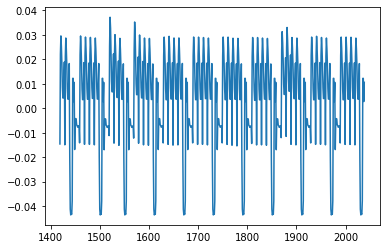

In [186]:
plt.figure()
plt.plot(curr.RF_results)
#plt.plot(curr.Residuals_pct_occupied_sarima)
plt.show()

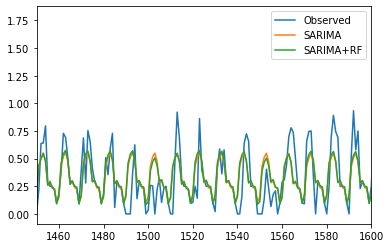

In [187]:
fig, ax = plt.subplots()
ax.plot(curr['PercentOccupied'], label='Observed')

ax.plot(curr['SARIMA_Preds'], label='SARIMA')
ax.plot(curr['SARIMA_Plus_RF'], label='SARIMA+RF')
ax.legend()
ax.set_xlim(1450,1600)
plt.show()

In [188]:
arima2_results = pd.read_pickle('arima_results2/arima_results.pkl')
arima2_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,SurroundsTest,NonSeasonal,Seasonal,p,d,q,P,D,Q,m
SourceElementKey,,,,,,,,,,,,,,,,,,
1001,26.778236,34.434702,1427,0.225284,"((0, 0, 3), (4, 0, 4, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.247...,"[0.30421134507792436, 0.22696330244619553, 0.1...","[0.29248498129242667, 0.29248498129242667, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.389...,"(0, 0, 3)","(4, 0, 4, 10)",0,0,3,4,0,4,10
1002,25.950885,37.279208,1427,0.183905,"((2, 0, 2), (2, 0, 2, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.237...,"[0.254857374389947, 0.2777993535872891, 0.0301...","[0.27232191637687037, 0.27232191637687037, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.371...,"(2, 0, 2)","(2, 0, 2, 10)",2,0,2,2,0,2,10
1006,24.222940,33.132488,1696,0.171301,"((4, 0, 2), (4, 0, 4, 12))",OccupancyDateTime 2019-06-21 13:00:00 0.507...,"[0.5059965728826651, 0.35324215008701726, 0.25...","[0.3211730913292586, 0.3211730913292586, 0.321...",OccupancyDateTime 2019-06-21 14:00:00 0.350...,"(4, 0, 2)","(4, 0, 4, 12)",4,0,2,4,0,4,12
1009,29.071818,38.520762,1712,0.162182,"((1, 0, 2), (4, 0, 4, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.436...,"[0.4442358711245875, 0.39905134806806686, 0.13...","[0.29087346552916865, 0.29087346552916865, 0.2...",OccupancyDateTime 2019-06-20 18:00:00 0.547...,"(1, 0, 2)","(4, 0, 4, 12)",1,0,2,4,0,4,12
1010,16.606980,24.154482,1712,0.203732,"((2, 0, 3), (2, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.620...,"[0.6311579389046404, 0.5975534116314929, 0.363...","[0.5597597884610469, 0.5597597884610469, 0.559...",OccupancyDateTime 2019-06-20 18:00:00 0.488...,"(2, 0, 3)","(2, 0, 3, 12)",2,0,3,2,0,3,12


In [189]:
arima2_results['ArimaPlusRFSmapeErrors'] = np.nan
for block in arima2_results.index.values:
    mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
    curr = merged[mask]
    if len(curr.SARIMA_Plus_RF) > 0:
    
        arima_rf_smape = smape_error(curr.SARIMA_Plus_RF, curr.PercentOccupied)
        arima2_results.at[block, 'ArimaPlusRFSmapeErrors'] = arima_rf_smape
    else:
        print(block)
        #print(arima_rf_smape, arima2_results.loc[block].ArimaSmapeErrors, arima2_results.loc[block].GBMSmapeErrors)

1037
1041
1045


In [190]:
arima2_results[['ArimaPlusRFSmapeErrors', 'ArimaSmapeErrors', 'GBMSmapeErrors']].dropna(axis=0).mean()

ArimaPlusRFSmapeErrors    24.086622
ArimaSmapeErrors          24.113754
GBMSmapeErrors            28.179039
dtype: float64